In [88]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph.state import StateGraph, START, END
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display,Markdown

load_dotenv()

True

In [89]:
gpt_llm= ChatOpenAI(model= "gpt-4o-mini")

In [90]:
class Classifier(BaseModel):
    workflow_type: Literal["Sequence","Parallel"] = Field(description="This field is a classfier of a question based on sequential chain or parallel chain")


In [91]:
structured_output = gpt_llm.with_structured_output(Classifier)

In [113]:
class State(TypedDict):
    topic: str
    workflow_type: str
    sequential_output: str
    sequence_summary_output: str
    parallel_blog_output: str
    parallel_bullets_output: str
    combine_parallel_output: str
    

In [93]:
def classifier_agent(state:State) -> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are a classifier assistant which classifies the user questions based on parallel or sequence flow."),
            ("human",f"please help in classifying the question from the user: {state['topic']}")
        ]
    )

    chain =  prompt_template | structured_output 

    response = chain.invoke({"topic":state['topic']})

    return {"workflow_type":response.workflow_type}
    

In [94]:
def classifier_condition(state:State) -> Literal["sequential_agent","parallel_agent"]:
    if state["workflow_type"]=="Sequence":
        return "sequential_agent"
    else:
        return "parallel_agent"

In [ ]:
def sequential_agent(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an LLM which generates 3 paragraph for the topic given by the user."),
            ("human",f"Please help in generating 3 paragraph for the topic: {state['topic']}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser() 

    response = chain.invoke({"topic":state['topic']})

    return {"sequential_output":response}

In [96]:
def sequential_agent_summarizer(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an LLM generator which helps in summarizing the output."),
            ("human",f"Please help in generating 3 paragraph for the output: {state['output']}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser() 

    response = chain.invoke({"output":state['output']})

    return {"sequence_summary_output":response}

In [97]:
def parallel_agent(state:State)-> State:

    return {"topic":state['topic']}

In [98]:
def parallel_agent_blog(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an LLM which generates 5 lines blogs for the topic given by the user."),
            ("human",f"Please help in generating 5 lines blogs for the topic: {state['topic']}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser() 

    response = chain.invoke({"topic":state['topic']})

    return {"parallel_blog_output":response}

In [99]:
def parallel_agent_bullets(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an agent that writes 5 bullet facts about the user topic"),
            ("human",f"Please help in generating 5 bullet facts about the topic: {state['topic']}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser() 

    response = chain.invoke({"topic":state['topic']})

    return {"parallel_bullets_output":response}

In [100]:
def parallel_agent_combinator(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an agent that helps combining both the blogs and bullet points."),
            ("human",f"Please help in combining blogs: \n \n {state["parallel_blog_output"]} and bullet facts: \n\n {state["parallel_bullets_output"]}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser()  

    response = chain.invoke({"parallel_blog_output":state["parallel_blog_output"], "parallel_bullets_output":state["parallel_bullets_output"]})

    return {"combine_parallel_output":response}

In [101]:
graph=StateGraph(State)

graph.add_node("classifier_agent",classifier_agent)
graph.add_node("sequential_agent",sequential_agent)
graph.add_node("sequential_agent_summarizer",sequential_agent_summarizer)
graph.add_node("parallel_agent",parallel_agent)
graph.add_node("parallel_agent_blog",parallel_agent_blog)
graph.add_node("parallel_agent_bullets",parallel_agent_bullets)
graph.add_node("parallel_agent_combinator",parallel_agent_combinator)


graph.add_edge(START, "classifier_agent")
graph.add_conditional_edges("classifier_agent",classifier_condition)
graph.add_edge("sequential_agent", "sequential_agent_summarizer")
graph.add_edge("sequential_agent_summarizer", END)
graph.add_edge("parallel_agent", "parallel_agent_blog")
graph.add_edge("parallel_agent", "parallel_agent_bullets")
graph.add_edge("parallel_agent_bullets", "parallel_agent_combinator")
graph.add_edge("parallel_agent_blog", "parallel_agent_combinator")
graph.add_edge("parallel_agent_combinator", END)


workflow=graph.compile()

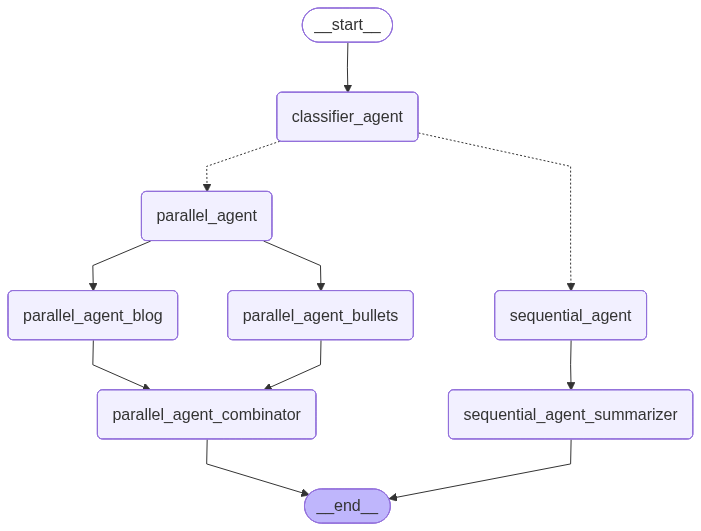

In [102]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [105]:
result=workflow.invoke({"topic":"what is parallel chain in langgraph?"})

In [108]:
Markdown(result["parallel_blog_output"])

Parallel chains in LangGraph represent a sophisticated structure allowing multiple processes to operate simultaneously, enhancing efficiency in language modeling. By enabling various branches to process data concurrently, it fosters improved understanding and generation of complex linguistic patterns. This framework can significantly reduce the time needed for training and inference, offering a robust solution for handling large datasets. Additionally, parallel chains facilitate the exploration of diverse contextual meanings, enriching the model's capability to generate nuanced text. In summary, they are pivotal for advancing the performance of language processing tasks within the LangGraph architecture.

In [109]:
Markdown(result["parallel_bullets_output"])

Here are 5 bullet facts about parallel chains in LangGraph:

1. **Concept Explanation**: A parallel chain in LangGraph refers to a structure where multiple processing paths run concurrently, allowing for simultaneous handling of tasks or information streams within a language processing framework.

2. **Efficiency**: By utilizing parallel chains, LangGraph can enhance efficiency in language tasks, as it allows different algorithms or models to operate in tandem, reducing the overall time required for complex tasks like translation or sentiment analysis.

3. **Scalability**: Parallel chains support scalability in natural language processing by enabling the framework to handle larger datasets or more complex models without a corresponding linear increase in processing time or resources.

4. **Modularity**: LangGraph's use of parallel chains promotes a modular architecture, where various components or layers can be developed, tested, and optimized independently, leading to more robust and flexible language processing solutions.

5. **Implementation**: In practice, implementing parallel chains in LangGraph can involve using techniques such as multi-threading or asynchronous processing to ensure that different strands of language processing can efficiently share resources and data without bottlenecks.

In [107]:
Markdown(result["combine_parallel_output"])

Certainly! Here's a combined version of the information from the blog and the bullet points on parallel chains in LangGraph:

---

**Parallel Chains in LangGraph**

Parallel chains in LangGraph represent a sophisticated structure that enhances the efficiency and scalability of language modeling by allowing multiple processes to operate simultaneously. This innovative architecture consists of various processing paths that run concurrently, enabling the simultaneous handling of tasks or information streams within the language processing framework.

### Key Features:

1. **Concept Explanation**: In LangGraph, a parallel chain refers to a structure enabling multiple processing paths to function concurrently. This design facilitates the simultaneous management of tasks, leading to an enriched understanding and generation of complex linguistic patterns.

2. **Efficiency**: Utilizing parallel chains significantly enhances efficiency in language processing tasks. By allowing different algorithms or models to operate in tandem, it reduces the overall time required for complex operations such as translation or sentiment analysis.

3. **Scalability**: The presence of parallel chains supports scalability in natural language processing. This allows LangGraph to handle larger datasets and more complex models without a corresponding linear increase in processing time or resources, making it suitable for extensive applications.

4. **Modularity**: LangGraph’s parallel chains promote a modular architecture. This modularity enables various components or layers to be developed, tested, and optimized independently, resulting in a more robust and flexible language processing solution.

5. **Implementation**: In practice, implementing parallel chains in LangGraph may involve techniques such as multi-threading or asynchronous processing. These techniques ensure that different strands of language processing can efficiently share resources and data without experiencing bottlenecks.

### Conclusion

In summary, parallel chains are pivotal for advancing the performance of language processing tasks within the LangGraph architecture. They facilitate the exploration of diverse contextual meanings, enriching the model's ability to generate nuanced text while significantly reducing the time necessary for training and inference on large datasets.

--- 

This combined text offers a comprehensive overview while integrating the detailed insights from the original blog and bullet points.

In [110]:
result

{'topic': 'what is parallel chain in langgraph?',
 'parallel_blog_output': "Parallel chains in LangGraph represent a sophisticated structure allowing multiple processes to operate simultaneously, enhancing efficiency in language modeling. By enabling various branches to process data concurrently, it fosters improved understanding and generation of complex linguistic patterns. This framework can significantly reduce the time needed for training and inference, offering a robust solution for handling large datasets. Additionally, parallel chains facilitate the exploration of diverse contextual meanings, enriching the model's capability to generate nuanced text. In summary, they are pivotal for advancing the performance of language processing tasks within the LangGraph architecture.",
 'parallel_bullets_output': "Here are 5 bullet facts about parallel chains in LangGraph:\n\n1. **Concept Explanation**: A parallel chain in LangGraph refers to a structure where multiple processing paths run 

In [111]:
result=workflow.invoke({"topic":"what is sequencing in database?"})

In [114]:
Markdown(result["output"])

Sequencing in a database refers to the process of defining a specific order for data entries within a table. This can relate to the arrangement of records based on one or more attributes or fields, often to facilitate efficient data retrieval, enhance readability, or maintain data integrity. For example, sequencing can enable a database to sort customer records by their names, transaction dates, or any other relevant identifier, making it easier for users to locate specific entries or analyze trends over time. By implementing sequencing, databases can effectively manage large volumes of data while ensuring that it remains accessible and organized.

In relational databases, sequencing is often implemented through unique constraints like primary keys, which enforce a particular order for records. Additionally, databases can use auto-incrementing fields to create a sequence of unique numeric identifiers for each record, ensuring that each entry can be uniquely identified and referenced. This is particularly valuable in scenarios where new records are frequently added and maintaining a consistent order is essential for application functionality. Moreover, database management systems often provide various indexing techniques that enhance query performance by utilizing the established sequences of data.

Sequencing is also crucial in scenarios where transactional integrity is paramount. In environments employing multiple concurrent users or processes interacting with the database, maintaining a defined sequence of operations can prevent data inconsistencies and ensure data integrity. For example, in a banking application, the sequence of transactions must be strictly adhered to, as later operations may depend on the results of previous ones. Overall, effective sequencing practices play a fundamental role in optimizing database performance, ensuring data consistency, and facilitating accurate data analysis.

In [115]:
Markdown(result["sequence_summary_output"])

Sequencing in a database is a method used to establish a specific order for data entries within a table. This process can involve organizing records based on various attributes or fields to improve data retrieval efficiency, enhance readability, and maintain data integrity. For instance, sequencing allows for sorting customer records by names, transaction dates, or other identifiers, which aids users in easily locating specific entries and analyzing trends over time. As a result, databases that implement sequencing can effectively manage large volumes of data while ensuring its accessibility and organization.

In relational databases, the implementation of sequencing is often achieved through unique constraints such as primary keys, which provide a systematic order for records. Auto-incrementing fields create unique numeric identifiers for each record, allowing for distinct references and support in scenarios where new records are frequently added. This is vital for maintaining consistency in order, especially in applications where the functionality relies on an ordered sequence. Furthermore, database management systems often utilize various indexing techniques that leverage established sequences to optimize query performance.

Sequencing is also essential in maintaining transactional integrity, particularly in environments with multiple concurrent users interacting with the database. Adhering to a defined sequence of operations can help prevent data inconsistencies and assure data integrity. For example, in a banking application, it is critical to follow the correct sequence of transactions since subsequent operations may rely on the outcomes of previous ones. Effective sequencing practices thus play a key role in optimizing database performance, ensuring data consistency, and facilitating accurate data analysis, making it a foundational aspect of database management.

In [116]:
result

{'topic': 'what is sequencing in database?',
 'output': 'Sequencing in a database refers to the process of defining a specific order for data entries within a table. This can relate to the arrangement of records based on one or more attributes or fields, often to facilitate efficient data retrieval, enhance readability, or maintain data integrity. For example, sequencing can enable a database to sort customer records by their names, transaction dates, or any other relevant identifier, making it easier for users to locate specific entries or analyze trends over time. By implementing sequencing, databases can effectively manage large volumes of data while ensuring that it remains accessible and organized.\n\nIn relational databases, sequencing is often implemented through unique constraints like primary keys, which enforce a particular order for records. Additionally, databases can use auto-incrementing fields to create a sequence of unique numeric identifiers for each record, ensuring t